# Challenge V

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 39.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
! pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.8 MB/s eta 0:00:00


In [4]:
!pip install accelerate -U

In [5]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import accelerate

In [49]:
import pandas as pd

## Configurations

In [6]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

## Data load



In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset("financial_phrasebank","sentences_50agree")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})

In [10]:
dataset['train'][2]

{'sentence': 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .',
 'label': 0}

## Splitting dataset into training and test.

In [11]:
splited_dataset = dataset["train"].train_test_split(test_size=0.2)

In [12]:
splited_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 970
    })
})

## Exploratory analysis

In [13]:
# Convert the train and test datasets to pandas DataFrames
all_df = dataset["train"].to_pandas()

In [14]:
all_df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


In [15]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4846 non-null   object
 1   label     4846 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [16]:
all_df['label'].value_counts()/(all_df['label'].shape[0])

label
1    0.594098
2    0.281263
0    0.124639
Name: count, dtype: float64

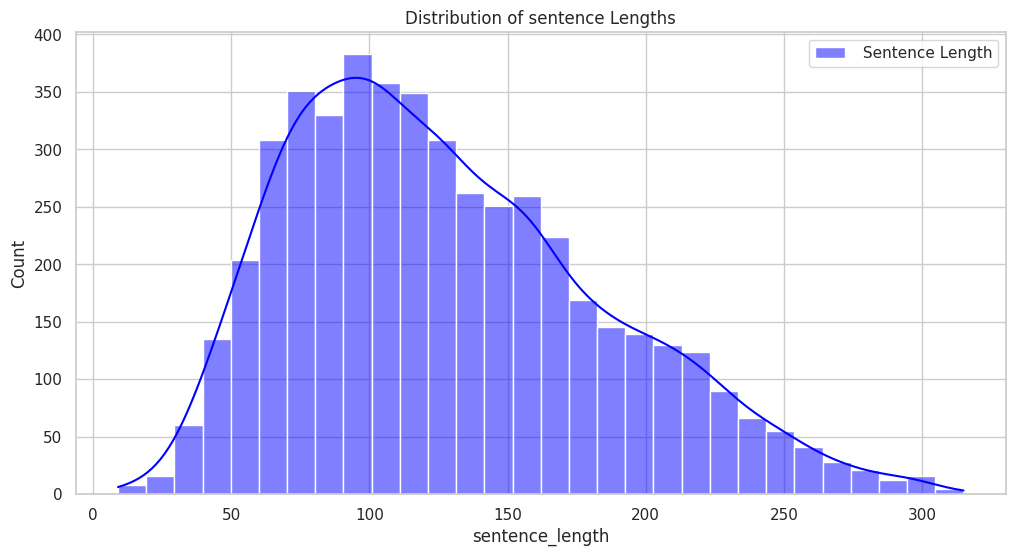

In [17]:
# Setting the aesthetic style for the plots
sns.set_theme(style="whitegrid")

# Visualizing message lengths
all_df["sentence_length"] = all_df["sentence"].apply(len)


plt.figure(figsize=(12, 6))
sns.histplot(
    all_df["sentence_length"],
    bins=30,
    label=" Sentence Length",
    kde=True,
    color="blue",
)

plt.legend()
plt.title("Distribution of sentence Lengths")
plt.show()

In [18]:
df_list=all_df['sentence'].to_list()

In [19]:
def l(num_label):
  if num_label==0:
    av='negative'
  elif num_label==1:
    av='neutral'
  else:
    av='positive'
  return av

In [20]:
all_df['label_actual']=all_df['label'].apply(lambda x: l(x))

In [21]:
actual_label=all_df['label_actual'].to_list()

## Model FinBert 'As Is'

In [22]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Model specifically fine-tuned for sentiment analysis
model_name = "ProsusAI/finbert"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [23]:
def encode_text(text, tokenizer):
    # Encode text to suitable input format for the model
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=300)
    return encoded_input

In [24]:
encoded_input = encode_text(df_list, tokenizer)

In [25]:
# Predicting the sentiments
with torch.no_grad():
    outputs = model(**encoded_input)

# Get prediction results
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_classes = torch.argmax(predictions, dim=1)
predicted_labels = [model.config.id2label[prediction.item()] for prediction in predicted_classes]

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
# Calculate confusion matrix
cm = confusion_matrix(actual_label, predicted_labels)

print(cm)

[[ 586   11    7]
 [ 122 2470  287]
 [  22   86 1255]]


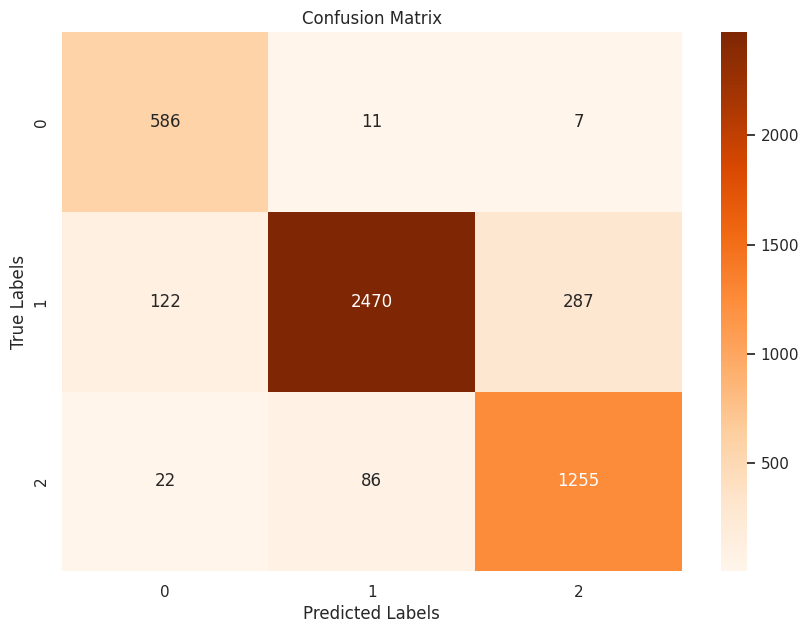

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
# Calculate Accuracy
accuracy = accuracy_score(actual_label, predicted_labels)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(actual_label, predicted_labels, average='macro')  # 'macro' is one of the methods to handle multi-class classification
print("Precision:", precision)

# Calculate Recall
recall = recall_score(actual_label, predicted_labels, average='macro')
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(actual_label, predicted_labels, average='macro')
print("F1 Score:", f1)

Accuracy: 0.8895996698307883
Precision: 0.8583841849307839
Recall: 0.9162994939486847
F1 Score: 0.8825330133105712


## distilGPT-2


In [ ]:
model_checkpoint = "distilgpt2"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenize_function(example):
    # Assuming example['message_2'] are the fields you want to tokenize
    tokenized_output = tokenizer(
        example["sentence"], padding="max_length", truncation=True, return_tensors="np"
    )
    return {
        "input_ids": tokenized_output["input_ids"].tolist(),
        "attention_mask": tokenized_output["attention_mask"].tolist(),
    }

In [ ]:
tokenized_datasets_gpt = splited_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["sentence","label"],
)

In [ ]:
tokenized_datasets_gpt

In [ ]:
block_size = 128  # Set your block size appropriately

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets_gpt.map(
    group_texts,
    batched=True,
    batch_size=1024,
)

## Training Distil GPT-2

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

In [ ]:
LR=0.01

In [ ]:
training_args = TrainingArguments(
    f"{model_name}-fine-tuned",
    evaluation_strategy="epoch",
    learning_rate=LR,
    weight_decay=LR * 0.1,
    push_to_hub=False, # este atributo lo pueden utilizar para mandar el modelo a Hugging Face
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
)

In [ ]:
trainer.train()

In [ ]:
import torch
torch.cuda.is_available()

# Using GPT-2

In [31]:
from transformers import GPT2Model, GPT2Config, GPT2ForSequenceClassification
import torch

# Load the GPT-2 model configuration and modify it for sequence classification
config = GPT2Config.from_pretrained('gpt2', num_labels=3)  # Adjust num_labels as per your task
model_gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', config=config)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
dataset_gpt = splited_dataset.map(lambda examples: {'labels': examples['label'], 'input_ids': tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=300)['input_ids']}, batched=True)


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [33]:
from transformers import GPT2Tokenizer

tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

def tokenize_function(examples):
    return tokenizer_gpt(examples['sentence'], padding="max_length", truncation=True, max_length=300)

# Apply tokenization
dataset_tokenized_gpt = dataset_gpt.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_gpt['train'],
    eval_dataset=dataset_gpt['test']
)


In [ ]:
model.config.pad_token_id = tokenizer_gpt.pad_token_id

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.673700,0.816695
2,0.480100,0.778600
3,0.204500,0.969264


TrainOutput(global_step=1455, training_loss=0.4194681191362466, metrics={'train_runtime': 225.8666, 'train_samples_per_second': 51.482, 'train_steps_per_second': 6.442, 'total_flos': 1780304326041600.0, 'train_loss': 0.4194681191362466, 'epoch': 3.0})

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2')

In [ ]:
tokenizer_gpt.save_pretrained('/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2')

('/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2/tokenizer_config.json',
 '/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2/special_tokens_map.json',
 '/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2/vocab.json',
 '/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2/merges.txt',
 '/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2/added_tokens.json')

In [34]:
from transformers import GPT2Tokenizer

# Load the tokenizer and model
model_path = '/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/Model/fine_tuned_gpt2'  # Adjust this path to where your fine-tuned model is saved

tokenizer_pretrained = GPT2Tokenizer.from_pretrained(model_path)
model_pretrained = GPT2ForSequenceClassification.from_pretrained(model_path)


In [35]:
def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=300, truncation=True, padding="max_length")
    return inputs


In [36]:
def get_prediction(text):
    # Prepare the text input
    inputs = prepare_input(text)

    # Predict using the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Process the model output, e.g., taking the argmax to get the predicted class index
    predictions = torch.argmax(outputs.logits, dim=-1)

    return predictions.item()  # Assuming you're predicting for one sample at a time



In [37]:
# Example usage
sample_text = "This is ridiculuous"
prediction = get_prediction(sample_text)
print(f"Predicted class index: {prediction}")

Predicted class index: 1


In [42]:
#Let's to predict
sentences_test=splited_dataset['test']['sentence']

In [45]:
#Predictions
pred = list(map(get_prediction, sentences_test))

In [50]:
pred_gpt=pd.DataFrame(pred)
pred_gpt.to_csv('/content/drive/MyDrive/Deep Learning/Semana 7/Challenge/GPT_prediction/gpt_prediction.csv')

In [ ]:
#using FinBert on test dataset only
